In [1]:
import os
import re
import pandas as pd
import numpy as np
import requests
import threading
from bs4 import BeautifulSoup
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap

from bao import cities, brands, articles, color


In [2]:
res = requests.get(f'https://www.ptt.cc/bbs/nb-shopping/index.html')
soup = BeautifulSoup(res.text, "lxml")

In [3]:
# Get number of pages in specific board.

page_num_str = re.sub('\D', '', soup.find("a", class_="btn wide", text="‹ 上頁")["href"])
page_num = int(page_num_str) + 1

In [4]:
test_num = page_num
thread_num = 32

titles = []
prices = []
locations = []

if not os.path.exists("dataset/articles.xlsx"):

    for i in range(0, test_num, thread_num):

        threads = []

        for t in range(min(thread_num,test_num-i)):
            page_idx = page_num - (i+t)
            threads.append(threading.Thread(target = articles.get_data, args = (i+t, page_idx, test_num, titles, prices, locations)))
            threads[t].start()    

        for t in range(min(thread_num,test_num-i)):
            threads[t].join()  

    print('\n100% Done!\n')

    df = pd.DataFrame({'Title': titles, 'Price': prices, 'Location': locations})
    df.to_excel('dataset/articles.xlsx', index=False)

df = pd.read_excel('dataset/articles.xlsx', dtype={'Title':str, 'Price':int, 'Location':str})

df

,Title,Price,Location
0,售出 DELL LATITUDE E7470,5500,新竹
1,ACER ASPIRE V3-372,7000,台北
2,ASUS G15 GA502IV-0024A4800H不賣了,33000,高雄
3,機械革命 CODE01 (售出),20000,台中
4,ASUS M515U 15吋銀灰,27000,新竹
...,...,...,...
41194,UL30VT~4G記憶體~7200轉硬碟,16000,北市
41195,SONY VAIO E系列17吋筆電(洽中),28000,台北
41196,UL30VT~4G記憶體~7200轉硬碟,16000,北市
41197,SONY VAIO E系列17吋筆電(洽中),28000,台北


In [5]:

# Location unifying.

for pattern, city in cities.patterns:
    df['Location'] = df['Location'].str.replace(pattern, city, regex=True)
df.loc[df['Location'] == '', 'Location'] = '全國'

# Brand unifying.

for pattern, brand in brands.patterns:
    df.loc[df['Title'].str.match(pattern, na=False), 'Title'] = brand
df = df.loc[df['Title'].str.match(brands.all_brands(), na=False)]

df.to_excel('dataset/unified.xlsx', index=False)

In [6]:
brand_volumn = Counter()

# Compute trading volumn of different brands.

for brand in df['Title']:
    brand_volumn[brand] += 1

for brand, count in brand_volumn.most_common():
    print(f'{count}\t{brand}')

8500	ASUS
5212	Acer
5024	Lenovo
4804	Apple
3110	Surface
2572	MSI
1897	HP
1643	Dell
912	TOSHIBA
505	Sony
502	Gigabyte
364	CJS
160	LG
130	FUJITSU
55	Genuine


In [7]:
city_volumn = Counter()
city_mean = Counter()

# Compute trading volumn & mean prices in different locations.

for title, price, location_string in df.values:
    if price < 100000 and price > 500 and location_string == location_string and len(location_string)%2 == 0:
        for i in range(0, len(location_string), 2):
            location = location_string[i:i+2]
            city_volumn[location] += 1
            city_mean[location] += price

for key, mean in city_mean.items():
    city_mean[key] = mean // city_volumn[key]
    print(key, city_mean[key], city_volumn[key])
    

新竹 17533 2372
台北 20428 15627
高雄 17893 2367
台中 17871 3898
新北 20118 4360
全國 18097 4871
桃園 18224 2718
台南 19918 1879
彰化 17161 402
嘉義 19092 242
基隆 20786 174
屏東 16681 170
雲林 16123 92
宜蘭 17138 147
苗栗 17467 145
台東 16423 25
花蓮 15783 43
南投 15703 28


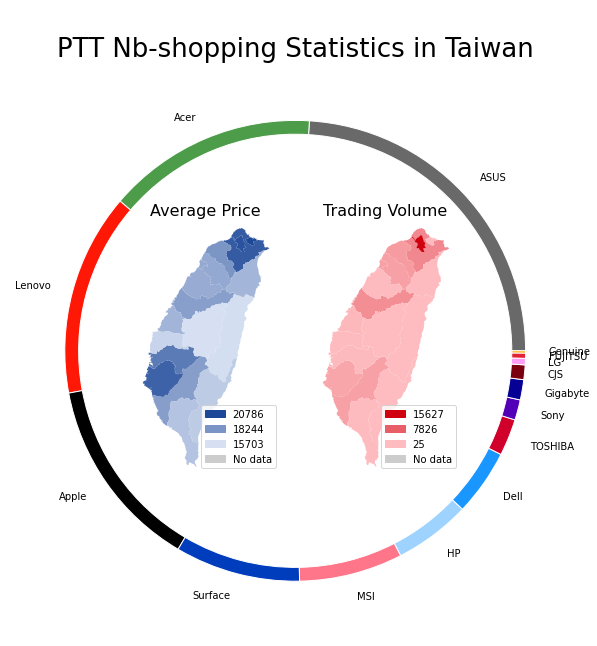

In [10]:
fig = plt.figure(figsize=(10,10))

ax_main = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax_price = fig.add_axes([0.2, 0.33, 0.35, 0.35])
ax_volumn = fig.add_axes([0.45, 0.33, 0.35, 0.35])

# Plot pie of different brands.

volumns = [ volumn for brand, volumn in brand_volumn.most_common() ]
colors = [ color.brand_color[brand] for brand, volumn in brand_volumn.most_common()]
names = [ brand for brand, volumn in brand_volumn.most_common()]

ax_main.pie(volumns , radius=1, colors=colors, wedgeprops=dict(width=0.06, edgecolor='w'), labels=names)


# Plot mean price & volumn on map.

map_price = Basemap(projection='gnom', lat_0=23.6, lon_0=121, width=240000, height=400000, resolution='l', ax=ax_price)
map_volumn = Basemap(projection='gnom', lat_0=23.6, lon_0=121, width=240000, height=400000, resolution='l', ax=ax_volumn)

map_price.readshapefile('shapefiles/Taiwan', name='Taiwan', linewidth=0.00001, drawbounds=True)
map_volumn.readshapefile('shapefiles/Taiwan', name='Taiwan', linewidth=0.00001, drawbounds=True)

max_price = max(city_mean.values())
min_price = min(city_mean.values())
for city, indices in cities.city_index.items():
    facecolor = color.get_color(city_mean[city], max_price, min_price, 'blue')
    for index in indices:
        poly = patches.Polygon(map_price.Taiwan[index], facecolor=facecolor)
        ax_price.add_patch(poly)

max_volumn = max(city_volumn.values())
min_volumn = min(city_volumn.values())
for city, indices in cities.city_index.items():
    facecolor = color.get_color(city_volumn[city], max_volumn, min_volumn, 'red')
    for index in indices:
        poly = patches.Polygon(map_volumn.Taiwan[index], facecolor=facecolor)
        ax_volumn.add_patch(poly)


# Add legens of price & volumn

ax_price.legend(handles=[
    patches.Patch(color=color.get_color(2, 2, 0, 'blue'), label=str(max_price)),
    patches.Patch(color=color.get_color(1, 2, 0, 'blue'), label=str((max_price+min_price)//2)),
    patches.Patch(color=color.get_color(0, 2, 0, 'blue'), label=str(min_price)),
    patches.Patch(color=color.get_color(3, 2, 0, 'red'), label='No data')
], loc = 'lower right')

ax_volumn.legend(handles=[
    patches.Patch(color=color.get_color(2, 2, 0, 'red'), label=str(max_volumn)),
    patches.Patch(color=color.get_color(1, 2, 0, 'red'), label=str((max_volumn+min_volumn)//2)),
    patches.Patch(color=color.get_color(0, 2, 0, 'red'), label=str(min_volumn)),
    patches.Patch(color=color.get_color(3, 2, 0, 'red'), label='No data')
], loc = 'lower right')


# Remove spines of each ax.

spines = ['top', 'right', 'bottom', 'left']
for spine in spines:
    ax_main.spines[spine].set_visible(False)
    ax_price.spines[spine].set_visible(False)
    ax_volumn.spines[spine].set_visible(False)


# Add titles.

ax_price.set_title('Average Price',fontdict={'fontsize':16})
ax_volumn.set_title('Trading Volume',fontdict={'fontsize':16})
ax_main.set_title('\nPTT Nb-shopping Statistics in Taiwan',fontdict={'fontsize':26})

fig.patch.set_facecolor('w')

plt.savefig('Taiwan.png')
plt.show()

